# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [126]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
sentiment_dev = pd.read_csv('data_sentiment/dev.csv', names=['text', 'label'])
sentiment_test = pd.read_csv('data_sentiment/test.csv', names=['text', 'label'])
sentiment_train = pd.read_csv('data_sentiment/train.csv', names=['text', 'label'])

If you use Pandas you can see a sample of the data.

In [3]:
sentiment_train.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
sentiment_dev_texts = list(sentiment_dev['text'])
sentiment_dev_labels = np.array(sentiment_dev['label'])

sentiment_test_texts = list(sentiment_test['text'])
sentiment_test_labels = np.array(sentiment_test['label'])

sentiment_train_texts = list(sentiment_train['text'])
sentiment_train_labels = np.array(sentiment_train['label'])

# Bag-of-Words Representation 

    
To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [5]:
stop_words = [
    'a', 'in', 'on', 'at', 'and', 'or', 'to', 'the', 'of', 'an', 'by', 'as',
    'is', 'was', 'were', 'been', 'be', 'are', 'for', 'this', 'that', 'these',
    'those', 'you', 'i', 'it', 'he', 'she', 'we', 'they'
    'will', 'have', 'has', 'do', 'did', 'can', 'could', 'who', 'which', 'what',
    'his', 'her', 'they', 'them', 'from', 'with', 'its'
]

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [116]:
def extract_ngrams(x_raw, ngram_range=(1, 3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=None, vocab=None):
    if stop_words is None:
        stop_words = []

    if vocab is None:
        vocab = set()

    tokens = [word for word in re.findall(token_pattern, x_raw) if word not in stop_words]

    ngrams = []

    for n in range(ngram_range[0], ngram_range[1] + 1):
        if n == 1:
            # Create unigram by concatenating list
            ngrams += tokens
        else:
            # Create bigram / trigram by unzipping list
            ngrams += zip(*(tokens[i:] for i in range(n)))
        
    
    return list(set(ngrams) & vocab) if vocab else ngrams

In [117]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [118]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [96]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=None, stop_words=None):
    if stop_words is None:
        stop_words = []
    
    vocab = set()
    df = Counter()
    ngram_counts = Counter()
    
    # A list containing each document's ngrams as sublist, e.g. [ [ngram, ngram, ...], ..., ]
    ngram_lists = (extract_ngrams(text, ngram_range, token_pattern, stop_words) for text in X_raw)
    
    for ngram_list in ngram_lists:
        # Count document frequency
        for ngram in set(ngram_list):
            df[ngram] += 1
        
        # Count ngram frequency
        for ngram in ngram_list
            if df[ngram] >= min_df:
                ngram_counts[ngram] += 1
    
    ngram_counts = ngram_counts.most_common(keep_topN)
    
    # Extract ngram into vocab set
    vocab = {ngram for (ngram, _) in ngram_counts}
    
    return vocab, df, ngram_counts

vocab, df, ngram_counts = get_vocab(sentiment_train_texts, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['scene', ('their', 'own'), 'loose', 'painful', 'hunt', ('based', 'novel'), 'sports', 'longer', 'committed', 'phone', 'heavy', 'selling', 'angeles', 'lose', 'ages', 'compare', ('couldn', 'help'), ('trust', 'me'), 'somebody', 'child', ('heavy', 'handed'), 'lie', ('don', 'want'), ('like', 'him'), 'foster', 'professional', ('only', 'two'), 'children', 'world', 'grand', 'frightened', 'stupidity', 'justice', 'porter', 'art', 're', 'meanwhile', 'fallen', ('just', 'right'), 'remarkably', ('whole', 'lot'), ('least', 'bit'), 'exceptions', 'fifteen', 'budget', 'prince', 'further', ('all', 'over'), 'line', 'everett', 'assault', 'frequency', 'especially', 'predictably', 'cynical', 'either', 'tales', ('john', 'carpenter'), 'aside', 'cards', 'violence', 'byrne', 'struggles', 'bag', 'agent', 'really', ('woody', 'allen'), 'mulder', 'student', 'eventually', 'investigation', 'city', ('kung', 'fu'), ('come', 'out'), 'makeup', 'officer', ('one', 'two'), 'danny', 'setup', 'colors', 'how', ('tim', 'ro

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
vocab, df, ngram_counts = get_vocab(sentiment_train_texts, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['manages', 'questions', 'covered', 'body', 'ron', 'flair', 'drunken', 'approach', 'etc', 'allowing', 'lebowski', 'strong', 'model', 'category', 'family', 'couldn', 'argento', 'why', 'shown', ('doesn', 'work'), 'ocean', ('lot', 'more'), 'lou', 'attorney', 'kick', 'thinking', 'worth', 'larger', ('waste', 'time'), ('back', 'forth'), 'roles', 'adventures', ('million', 'dollars'), 'critics', 'according', ('ghost', 'dog'), 'outside', 'protect', ('last', 'time'), ('but', 'so'), 'creative', 'sell', 'pile', 'needless', 'immediately', 'screens', 'cards', 'blonde', 'meets', 'place', 'needs', 'needed', 'teacher', 'conceived', 'competition', 'powerful', 'expected', ('first', 'movie'), ('but', 'least'), 'gave', 'pleasures', 'spectacular', 'safe', 'wishes', 'stuff', ('there', 'something'), 'robert', 'kid', 'latest', ('bad', 'guy'), 'comet', 'street', 'intelligent', 'allow', ('tim', 'roth'), ('production', 'design'), 'living', 'abyss', 'clean', ('makes', 'him'), 'aware', 'footage', 'vicious', '

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [102]:
id_to_word = enumerate(vocab)
id_to_word = dict(id_to_word)
print(id_to_word)

word_to_id = {value: key for key, value in id_to_word.items()}
print(word_to_id)

{0: 'scene', 1: ('their', 'own'), 2: 'loose', 3: 'painful', 4: 'hunt', 5: ('based', 'novel'), 6: 'sports', 7: 'longer', 8: 'committed', 9: 'phone', 10: 'heavy', 11: 'selling', 12: 'angeles', 13: 'lose', 14: 'ages', 15: 'compare', 16: ('couldn', 'help'), 17: ('trust', 'me'), 18: 'somebody', 19: 'child', 20: ('heavy', 'handed'), 21: 'lie', 22: ('don', 'want'), 23: ('like', 'him'), 24: 'foster', 25: 'professional', 26: ('only', 'two'), 27: 'children', 28: 'world', 29: 'grand', 30: 'frightened', 31: 'stupidity', 32: 'justice', 33: 'porter', 34: 'art', 35: 're', 36: 'meanwhile', 37: 'fallen', 38: ('just', 'right'), 39: 'remarkably', 40: ('whole', 'lot'), 41: ('least', 'bit'), 42: 'exceptions', 43: 'fifteen', 44: 'budget', 45: 'prince', 46: 'further', 47: ('all', 'over'), 48: 'line', 49: 'everett', 50: 'assault', 51: 'frequency', 52: 'especially', 53: 'predictably', 54: 'cynical', 55: 'either', 56: 'tales', 57: ('john', 'carpenter'), 58: 'aside', 59: 'cards', 60: 'violence', 61: 'byrne', 62:

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [121]:
sentiment_dev_vocab, sentiment_dev_df, sentiment_dev_ngram_counts = get_vocab(
    sentiment_dev_texts,
    ngram_range=(1, 3),
    keep_topN=5000,
    stop_words=stop_words)

sentiment_test_vocab, sentiment_test_df, sentiment_test_ngram_counts = get_vocab(
    sentiment_test_texts,
    ngram_range=(1, 3),
    keep_topN=5000,
    stop_words=stop_words)

sentiment_train_vocab, sentiment_train_df, sentiment_train_ngram_counts = get_vocab(
    sentiment_train_texts,
    ngram_range=(1, 3),
    keep_topN=5000,
    stop_words=stop_words)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [169]:
def vectorise(X_ngram, vocab):
    X_vec = []

    for ngram_list in X_ngram:
        counter = Counter(ngram_list)
        X_vec.append([counter[v] for v in vocab])

    X_vec = np.array(X_vec)

    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [170]:
sentiment_train_count = vectorise(
    (extract_ngrams(text, stop_words=stop_words) for text in sentiment_train_texts),
    sentiment_train_vocab)

In [171]:
sentiment_train_count.shape

(1400, 5000)

In [172]:
sentiment_train_count[:2,:50]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [17]:
# fill in your code...

Then transform your count vectors to tf.idf vectors:

In [18]:
# fill in your code...

In [19]:
X_tr_tfidf[1,:50]

array([0.        , 0.        , 0.        , 2.24028121, 0.        ,
       0.        , 0.        , 5.67501654, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       2.47354289, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 2.56209629,
       0.        , 0.        , 0.        , 0.        , 0.        ])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [20]:
def sigmoid(z):
    
    # fill in your code...
    
    return z

In [21]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [22]:
def predict_proba(X, weights):
    
    # fill in your code...
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [23]:
def predict_class(X, weights):
    
    # fill in your code...
    
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [24]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    # fill in your code...

    return l
    



Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [25]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # fill in your code...
    

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [26]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Epoch: 0| Training loss: 0.6281849626714022| Validation loss: 0.6459904270912492
Epoch: 1| Training loss: 0.58394973349301| Validation loss: 0.615917609244642
Epoch: 2| Training loss: 0.5505425987370951| Validation loss: 0.5920179207204117
Epoch: 3| Training loss: 0.5239076409919164| Validation loss: 0.5742090121213917
Epoch: 4| Training loss: 0.500731542158432| Validation loss: 0.5599256616458367
Epoch: 5| Training loss: 0.481386614351927| Validation loss: 0.5483399203516909
Epoch: 6| Training loss: 0.46462260481387196| Validation loss: 0.536726260641603
Epoch: 7| Training loss: 0.4500982582962053| Validation loss: 0.5293935827417584
Epoch: 8| Training loss: 0.4361300598154409| Validation loss: 0.5194135185643873
Epoch: 9| Training loss: 0.42421092133995136| Validation loss: 0.5128852380111468
Epoch: 10| Training loss: 0.41424666156856305| Validation loss: 0.5081058150491683
Epoch: 11| Training loss: 0.40290405763261916| Validation loss: 0.4998331750481731
Epoch: 12| Training loss: 0.

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

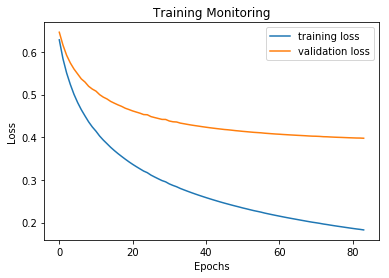

Explain here...

Compute accuracy, precision, recall and F1-scores:

In [10]:
# fill in your code...

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Finally, print the top-10 words for the negative and positive class respectively.

In [8]:
# fill in your code...

In [9]:
# fill in your code...

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [31]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.0001, 
                         alpha=0.00001, 
                         epochs=50)

Epoch: 0| Training loss: 0.496538116279205| Validation loss: 0.5895899274588817
Epoch: 1| Training loss: 0.4084394710560143| Validation loss: 0.544649086837174


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Epoch: 2| Training loss: 0.35196590407420064| Validation loss: 0.5150876603863132
Epoch: 3| Training loss: 0.3116844242022623| Validation loss: 0.49489773731674874
Epoch: 4| Training loss: 0.2810715774838783| Validation loss: 0.47997275137676726
Epoch: 5| Training loss: 0.25668747878708276| Validation loss: 0.46763654113258013
Epoch: 6| Training loss: 0.23654276549913594| Validation loss: 0.45767733688153556
Epoch: 7| Training loss: 0.21965240746100156| Validation loss: 0.4492067736453032
Epoch: 8| Training loss: 0.20518502986248432| Validation loss: 0.44195046817180716
Epoch: 9| Training loss: 0.1926379393530923| Validation loss: 0.4358175343417367
Epoch: 10| Training loss: 0.18161013121343478| Validation loss: 0.430927744935762
Epoch: 11| Training loss: 0.17183241812407454| Validation loss: 0.4267194647775054
Epoch: 12| Training loss: 0.1631180196151434| Validation loss: 0.42287948202462305
Epoch: 13| Training loss: 0.1552643554313739| Validation loss: 0.4185174243921952
Epoch: 14| T

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

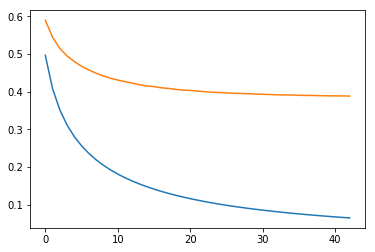

In [32]:
# fill in your code...

Compute accuracy, precision, recall and F1-scores:

In [11]:
# fill in your code...

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Print top-10 most positive and negative words:

In [13]:
# fill in your code...

In [14]:
# fill in your code...

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Enter your answer here...



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |   |   |   |
| BOW-tfidf  |   |   |   |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [16]:
topic_dev = pd.read_csv('data_topic/dev.csv', names=['label', 'text'])
topic_test = pd.read_csv('data_topic/test.csv', names=['label', 'text'])
topic_train = pd.read_csv('data_topic/train.csv', names=['label', 'text'])

In [17]:
topic_train.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [18]:
topic_dev_texts = list(topic_dev['text'])
topic_dev_labels = np.array(topic_dev['label'])

topic_test_texts = list(topic_test['text'])
label_test_labels = np.array(topic_test['label'])

topic_train_texts = list(topic_train['text'])
topic_train_labels = np.array(topic_train['label'])

In [39]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['questions', ('exhibition', 'game'), ('computer', 'maker'), ('chavez', 'won'), ('invoices', 'halliburton'), ('den', 'hoogenband', 'netherlands'), 'body', ('anterior', 'cruciate'), ('billion', 'cash', 'stock'), ('nortel', 'networks', 'corp'), ('offering', 'nearly'), ('prime', 'minister'), ('july', 'first', 'time'), 'strong', ('hang', 'over'), 'model', 'ease', 'assets', 'category', 'family', 'disappeared', ('olympic', 'men'), 'couldn', 'why', 'shift', ('world', 'largest', 'food'), 'oust', ('settler', 'homes'), ('jerusalem', 'reuters'), ('wisconsin', 'reuters'), 'luis', 'bowl', ('monday', 'said', 'quarterly'), ('baltimore', 'orioles'), ('more', 'israeli'), ('army', 'had', 'decided'), 'economic', ('after', 'web', 'no'), 'lynn', ('defensive', 'end'), 'according', 'facilities', ('company', 'wednesday'), ('lt', 'gt', 'wednesday'), 'tutsi', ('dillard', 'inc'), 'outside', 'protect', 'uk', 'weather', 'sell', 'pile', 'immediately', 'senate', ('venus', 'williams'), ('four', 'months'), 'pope

In [40]:
# fill in your code...

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [42]:
def softmax(z):
    
    # fill in your code...
    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [43]:
def predict_proba(X, weights):
    
    # fill in your code...
    
    return preds_proba

In [44]:
def predict_class(X, weights):
    
    # fill in your code...
    
    return preds_class

Toy example and expected functionality of the functions above:

In [45]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [46]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [47]:
predict_class(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [1]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    
    # fill in your code...
    
    return l
    

Finally you need to modify SGD to support the categorical cross entropy loss:

In [49]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    
    # fill in your code...

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [50]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Epoch: 0| Training loss: 1.0797445295473487| Validation loss: 1.081372090349833
Epoch: 1| Training loss: 1.079316160352198| Validation loss: 1.0640685482079149
Epoch: 2| Training loss: 1.0560473439817515| Validation loss: 1.0466716664674833
Epoch: 3| Training loss: 1.0823272116547453| Validation loss: 1.0293144599016153
Epoch: 4| Training loss: 1.0541411400498168| Validation loss: 1.0120430537618956
Epoch: 5| Training loss: 0.6018201485747277| Validation loss: 0.9949501699020834
Epoch: 6| Training loss: 0.9408020769124341| Validation loss: 0.9780518842493735
Epoch: 7| Training loss: 0.9785218029526777| Validation loss: 0.961399507260303
Epoch: 8| Training loss: 1.105504123262664| Validation loss: 0.945017429821232
Epoch: 9| Training loss: 0.9330426453622344| Validation loss: 0.9289397744769093
Epoch: 10| Training loss: 0.7202271854150083| Validation loss: 0.9131712383598369
Epoch: 11| Training loss: 0.980165568395653| Validation loss: 0.8977588631301825
Epoch: 12| Training loss: 0.9350

Epoch: 100| Training loss: 0.5909452468922335| Validation loss: 0.3308943792523601
Epoch: 101| Training loss: 0.0582537404726638| Validation loss: 0.3286410364885621
Epoch: 102| Training loss: 0.8460500582683682| Validation loss: 0.32641969802577286
Epoch: 103| Training loss: 0.5298538159246153| Validation loss: 0.324225708977352
Epoch: 104| Training loss: 0.3002611196487631| Validation loss: 0.3220709147432522
Epoch: 105| Training loss: 0.6857676458335961| Validation loss: 0.31995106501678755
Epoch: 106| Training loss: 0.5195060392225062| Validation loss: 0.31785403975508386
Epoch: 107| Training loss: 0.6192846034415994| Validation loss: 0.3157920207863501
Epoch: 108| Training loss: 0.09917322459957126| Validation loss: 0.31376264796419107
Epoch: 109| Training loss: 0.3136491065708976| Validation loss: 0.3117644717911298
Epoch: 110| Training loss: 0.2961228303588815| Validation loss: 0.30979000698586306
Epoch: 111| Training loss: 0.028415357821764815| Validation loss: 0.30785497759094

Plot training and validation process and explain if your model overfit, underfit or is about right:

In [2]:
# fill in your code...

Compute accuracy, precision, recall and F1-scores:

In [6]:
# fill in your code...

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Print the top-10 words for each class respectively.

In [7]:
# fill in your code...

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Explain here...

### Now evaluate BOW-tfidf...

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |   |   |   |
| BOW-tfidf  |   |   |   |
